## Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Задание 1

На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – *user_id*, тип выборки *variant_name* и доход принесенный пользователем *revenue*.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [2]:
df = pd.read_excel('AB_Test_Results (2) (1).xlsx')
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [4]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [5]:
double = df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique}).query('VARIANT_NAME > 1')
double

,USER_ID,VARIANT_NAME
1,3,2
6,10,2
11,18,2
15,25,2
23,40,2
...,...,...
6310,9978,2
6311,9979,2
6313,9982,2
6321,9996,2


In [6]:
df = df[~df['USER_ID'].isin(double['USER_ID'])].sort_values('USER_ID').reset_index(drop=True)
df

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,2,control,0.0
2,2,control,0.0
3,4,variant,0.0
4,5,variant,0.0
...,...,...,...
6065,9992,control,0.0
6066,9993,control,0.0
6067,9995,variant,0.0
6068,9995,variant,0.0


In [7]:
df = df.drop_duplicates().reset_index(drop=True)
df

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4816,9990,variant,0.0
4817,9992,control,0.0
4818,9993,control,0.0
4819,9995,variant,0.0


Из 10000 записей осталось 4821 (48%).
Первая рекомендация: проверить систему сплитования трафика.

In [8]:
df['REVENUE'].describe()

count    4821.000000
mean        0.134802
std         2.999336
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       196.010000
Name: REVENUE, dtype: float64

In [9]:
df['VARIANT_NAME'].value_counts()

control    2414
variant    2407
Name: VARIANT_NAME, dtype: int64

In [10]:
df['conversion'] = df['REVENUE'].apply(lambda x: int(x>0))
df.pivot_table(index='VARIANT_NAME',
               columns='conversion',
               values='USER_ID',
               aggfunc='count',
               margins=True)

conversion,0,1,All
VARIANT_NAME,,,
control,2360,54,2414
variant,2364,43,2407
All,4724,97,4821


In [11]:
A = df.query('VARIANT_NAME == "control"')
B = df.query('VARIANT_NAME == "variant"')
n1, n2 = A.shape[0], B.shape[0]
m1, m2 = A[A['conversion']==1].shape[0], B[B['conversion']==1].shape[0]

In [12]:
p1, p2 = m1/n1, m2/n2
p1, p2

(0.02236951118475559, 0.017864561695056087)

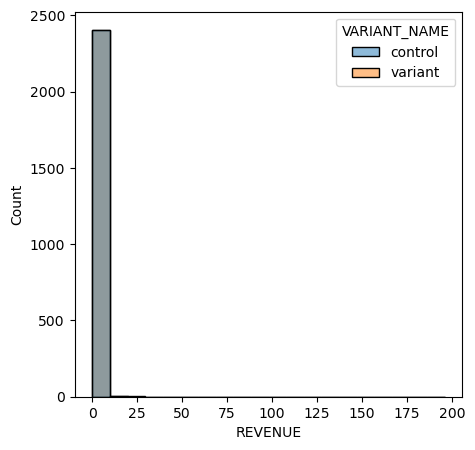

In [13]:
plt.figure(figsize=(5, 5))
sns.histplot(data=df, x='REVENUE', bins=20, hue='VARIANT_NAME');

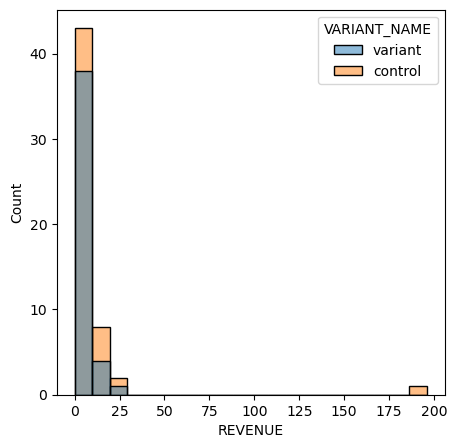

In [14]:
plt.figure(figsize=(5, 5))
sns.histplot(data=df[df['conversion']==1], x='REVENUE', bins=20, hue='VARIANT_NAME');

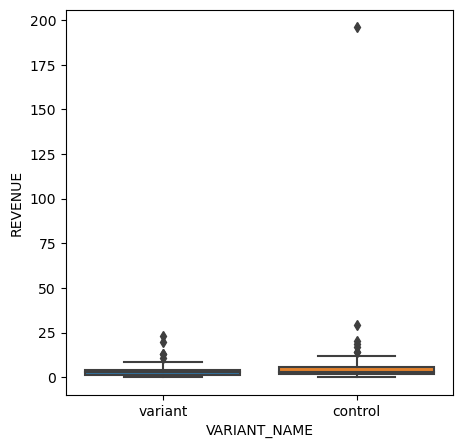

In [15]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=df[df['conversion']==1], y='REVENUE', x='VARIANT_NAME');

По графикам видно, что группа B хуже, чем группа А.
Низкая конверсия в покупку, причем в тестовой группе метрика ниже, чем в контрольной.
Вторая рекомендация: проверить длительность теста

Т.к. распределение ненормальное,то используем критерий Манна-Уитни.

In [17]:
stats.mannwhitneyu(x=A['REVENUE'].values, y=B['REVENUE'].values)

MannwhitneyuResult(statistic=2918468.0, pvalue=0.26069244720791673)

статистически значимой разницы между группами нет.

In [18]:
M1, M2 = A['REVENUE'].mean(), B['REVENUE'].mean()
D1, D2 = A['REVENUE'].var(), B['REVENUE'].var()

In [19]:
effect_size = (M1-M2)/np.sqrt(((n1-1)*D1 + (n2-1)*D2)/(n1+n2-2))
effect_size

0.04015622200080911

In [20]:
analysis = TTestIndPower()
analysis.solve_power(effect_size=effect_size, alpha=alpha, power=None, nobs1=n1, ratio=n2/n1)

0.28604403873041323

Мощность теста в районе 29%. С такой мощностью мы не можем быть уверены в результатах теста. 

рекомендации:

Не вводить изменения, на которых происходило тестирование группы B.
Уточнить дизайн А/В теста и запустить его заново.